In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfieldSparse
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
# # Best Hyperparameters so far
# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([1, 0.75]), 'fb': np.array([0.15, 0.12])}

# neural_lr_start = 0.05
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 5
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.5
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False

activation = None
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.999999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.12, 0.04]), 'fb': np.array([0.15, 0.02])}

neural_lr_start = 0.01
neural_lr_stop = 0.001
STlambda_lr_list = [0.0001, 0.000001]
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 20
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False


model = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfieldSparse(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.08111666666666667


In [6]:
# _ = evaluateContrastiveCorInfoMaxHopfieldSparse_topk( model, train_loader, hopfield_g,
#                                                       neural_lr_start, neural_lr_stop, STlambda_lr, 
#                                                       neural_lr_rule, 
#                                                       neural_lr_decay_multiplier, 
#                                                       neural_dynamic_iterations_free, device)

In [ ]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 30

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [01:26, 34.69it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.29595, Test Accuracy : 0.2893
Free Information ratio: [0.02027429]
Nudged Information ratio: [0.02027421]


3000it [01:27, 34.14it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.5680833333333334, Test Accuracy : 0.5661
Free Information ratio: [0.01983931]
Nudged Information ratio: [0.0198396]


3000it [01:27, 34.18it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.6665666666666666, Test Accuracy : 0.6665
Free Information ratio: [0.00944399]
Nudged Information ratio: [0.00945282]


3000it [01:24, 35.43it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098
Free Information ratio: [0.01889686]
Nudged Information ratio: [0.01889549]


3000it [01:27, 34.20it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098
Free Information ratio: [nan]
Nudged Information ratio: [nan]


3000it [01:27, 34.12it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.09871666666666666, Test Accuracy : 0.098
Free Information ratio: [nan]
Nudged Information ratio: [nan]


3000it [01:25, 35.26it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/kuacc/users/bbozkurt15/.conda/envs/bbozkurt15/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_127133/1980999210.py", line 23, in <module>
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start,
  File "../../src/torch_utils.py", line 284, in evaluateContrastiveCorInfoMaxHopfieldSparse
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, hopfield_g, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, neural_lr_decay_multiplier, T, beta = 0)
  File "../../src/ContrastiveModels.py", line 672, in run_neural_dynamics_hopfield
    apical_voltage = (gam_ * B[jj]['weight'] @ ( layers[jj + 1]) + hopfield_g * layers[jj + 1]) - beta * (layers[jj + 1] - y)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (mos

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/kuacc/users/bbozkurt15/.conda/envs/bbozkurt15/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_127133/1980999210.py", line 23, in <module>
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start,
  File "../../src/torch_utils.py", line 284, in evaluateContrastiveCorInfoMaxHopfieldSparse
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, hopfield_g, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, neural_lr_decay_multiplier, T, beta = 0)
  File "../../src/ContrastiveModels.py", line 672, in run_neural_dynamics_hopfield
    apical_voltage = (gam_ * B[jj]['weight'] @ ( layers[jj + 1]) + hopfield_g * layers[jj + 1]) - beta * (layers[jj + 1] - y)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (mos

In [7]:
model.save_model_weights(pickle_name = "CorInfoTrial")

In [7]:
model2 = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation)


KeyboardInterrupt: 

In [ ]:
model2.load_model_weights("CorInfoTrial")

In [ ]:
tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                        neural_lr_stop, STlambda_lr, neural_lr_rule, 
                                                        neural_lr_decay_multiplier, 
                                                        neural_dynamic_iterations_free, 
                                                        device, printing = True)

In [ ]:
tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model2, test_loader, hopfield_g, neural_lr_start, 
                                                        neural_lr_stop, STlambda_lr, neural_lr_rule, 
                                                        neural_lr_decay_multiplier, 
                                                        neural_dynamic_iterations_free, 
                                                        device, printing = True)

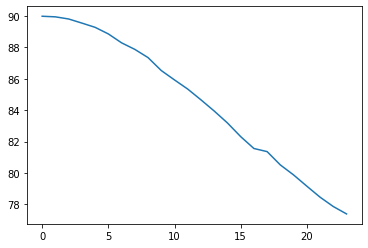

In [8]:
plt.plot(model.forward_backward_angles)

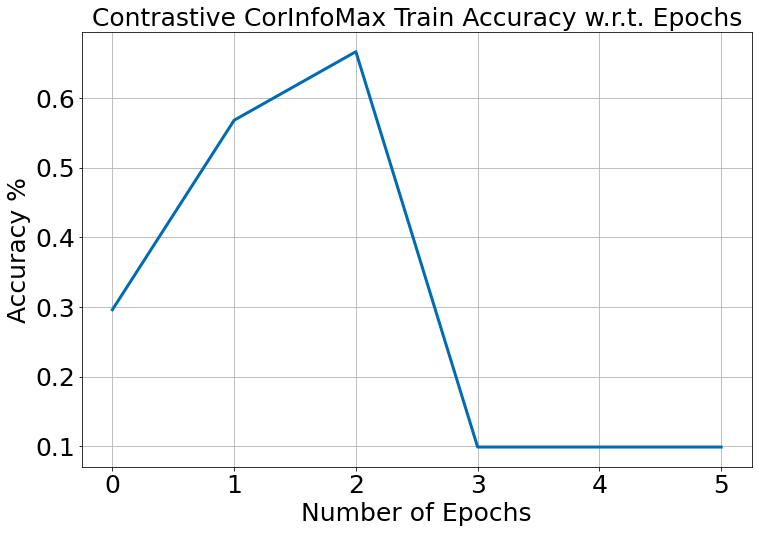

In [9]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [ ]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])